<a href="https://colab.research.google.com/github/Gokul0Krishna/pytorchpractice/blob/master/testingmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/the precious.zip"

Archive:  /content/the precious.zip
   creating: the precious/
  inflating: the precious/classifier.pth  
  inflating: the precious/classifier_state_dict.pth  


In [1]:
!unzip "/content/fmodeltest.zip"

Archive:  /content/fmodeltest.zip
   creating: test/
  inflating: test/P6171199_JPG.rf.5f2c7de501bbedda9884c60099ee72f0.jpg  
  inflating: test/P6171216_JPG.rf.a064710a27823ae8f08530e8ad651350.jpg  
  inflating: test/P6171222_JPG.rf.e6934a90f741c1c5d9c1352ebb619caf.jpg  
  inflating: test/P6171226_JPG.rf.d20a1bb2d1e46edd89e8031e2e66bbfe.jpg  
  inflating: test/P6171230_JPG.rf.690bf86e09c1569d8f61b1d6be04284f.jpg  
  inflating: test/P6171239_JPG.rf.b5e48a8a6e8bcd81ded841a0d242568a.jpg  
  inflating: test/P6171248_JPG.rf.63fc65e35fa46ed9d37b367da2feaebe.jpg  
  inflating: test/P6171258_JPG.rf.2911f0955a7aec5fa711486c74bebab1.jpg  
  inflating: test/P6171263_JPG.rf.d12d03d14c69d7a278f0bfac95369ea2.jpg  
  inflating: test/P6171297_JPG.rf.cb4496e6a764fceb265d2829e94db018.jpg  
  inflating: test/P6171301_JPG.rf.ed2eec04f64e5e3440771c80ab08f053.jpg  
  inflating: test/P6171312_JPG.rf.650fa1ca82dc1d1669befab5860c3006.jpg  
  inflating: test/P6171333_JPG.rf.30b10d6d932866b880f463a96cff2327.jpg 

In [2]:
import pandas as pd
df=pd.read_csv("/content/test/_classes.csv")

In [3]:
df.head()
l=["Ecrou NOK"	,"Ecrou Ok"	,"Rondelle NOK"	,"Rondelle OK"	,"Vis NOK"	,"Vis OK"]
df.set_index('filename',inplace=True)
res =  df[df==1].stack().reset_index().drop(0, axis=1)
res.head()

,filename,level_1
0,P6171491_JPG.rf.19e938b88b3425361e23f15ec5bdba...,Ecrou NOK
1,P6171353_JPG.rf.739351d214a4c8b22fa27d9cdc48a5...,Rondelle NOK
2,P6171239_JPG.rf.b5e48a8a6e8bcd81ded841a0d24256...,Rondelle OK
3,P6181722_JPG.rf.f21304384e6391874098137429bbdd...,Rondelle OK
4,P6171517_JPG.rf.644bea307bf3945f208a3d7c7a6723...,Ecrou Ok


In [4]:
for i in range(len(res)-1, -1, -1):
  if res.iloc[i,1]=="Vis NOK" or 	res.iloc[i,1]=="Vis OK":
    res.drop(i,inplace=True)

In [5]:
res=res.replace('Ecrou NOK',"nut")
res=res.replace('Ecrou Ok',"nut")

res=res.replace('Rondelle NOK',"washer")
res=res.replace('Rondelle OK',"washer")

In [6]:
res['level_1'].unique()

array(['nut', 'washer'], dtype=object)

In [7]:
for i in res['filename']:
  res=res.replace(i,"/content/test/"+i)

In [8]:
res=pd.get_dummies(res,columns=['level_1'],dtype=float)
res.columns = res.columns.str.replace("level_1_", "")
res.head()

,filename,nut,washer
0,/content/test/P6171491_JPG.rf.19e938b88b342536...,1.0,0.0
1,/content/test/P6171353_JPG.rf.739351d214a4c8b2...,0.0,1.0
2,/content/test/P6171239_JPG.rf.b5e48a8a6e8bcd81...,0.0,1.0
3,/content/test/P6181722_JPG.rf.f21304384e639187...,0.0,1.0
4,/content/test/P6171517_JPG.rf.644bea307bf3945f...,1.0,0.0


In [9]:
df=res.copy()

In [10]:
from PIL import Image
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models,transforms
from torch.utils.data import DataLoader,Dataset
import numpy as np
import seaborn as sns

In [11]:
class customdataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        imgpath=self.x.iloc[index]
        if self.transform:
            image=Image.open(imgpath).convert("RGB")
            image=self.transform(image)
        label_row = self.y.iloc[index, 0:2]
        label_tensor = torch.tensor(label_row.values.astype(np.float32))
        label_index = torch.argmax(label_tensor).item()

        return image,label_index

In [12]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [13]:
l=['washer','nut']
testdataset=customdataset(x=df['filename'],y=df[l],transform=preprocess)
testloader = DataLoader(testdataset, batch_size=16, shuffle=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
loaded_model = torch.load("/content/newclassifier.pth",weights_only=False,map_location=device)

In [16]:
from sklearn.metrics import confusion_matrix
loaded_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = loaded_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

confmatx=confusion_matrix(all_labels, all_preds, labels=np.arange(2))

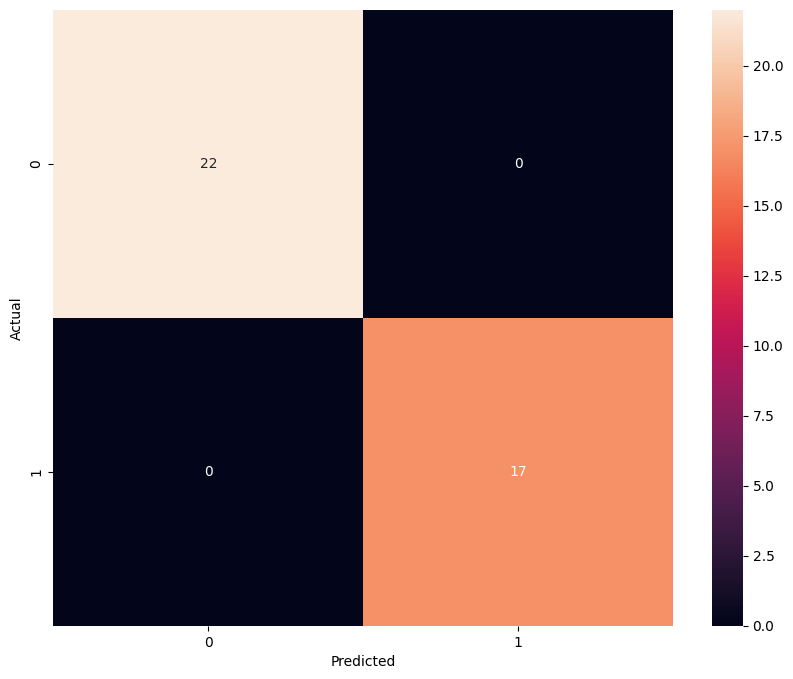

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(confmatx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
    }

for i in range(confmatx.shape[0]):
    TP = confmatx[i, i]
    FP = np.sum(confmatx[:, i]) - TP
    FN = np.sum(confmatx[i, :]) - TP

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    metrics['precision'].append(precision)
    metrics['recall'].append(recall)
    metrics['f1'].append(f1)


In [19]:
for i in metrics:
  print(f"{i}:{np.mean(metrics[i])}")

precision:0.9999999999947862
recall:0.9999999999947862
f1:0.9999999999447863


In [20]:
!unzip "/content/irltest.zip"

Archive:  /content/irltest.zip
   creating: irltest/
  inflating: irltest/image2.png      
  inflating: irltest/image3.png      
  inflating: irltest/image4.png      


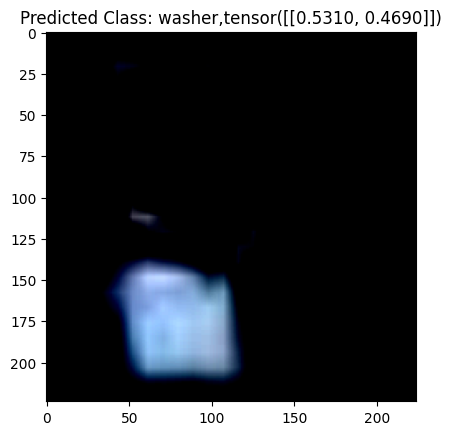

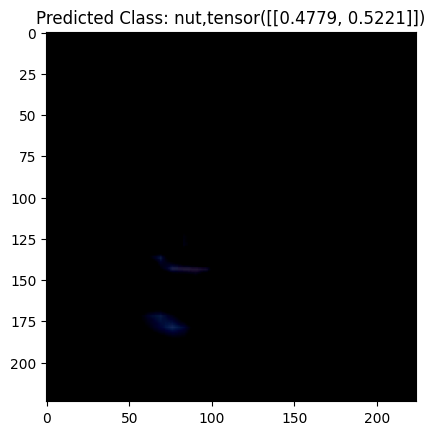

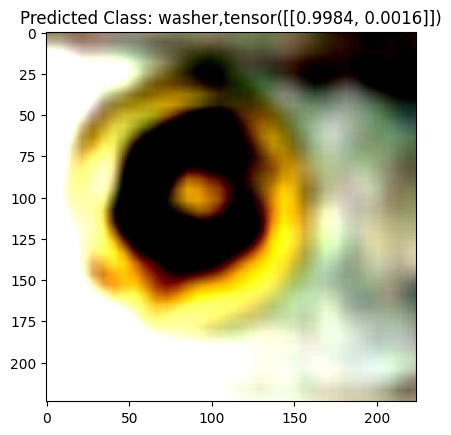

In [22]:
import os
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
import cv2
from matplotlib import pyplot as plt
loaded_model.eval()
for i in os.listdir("/content/irltest"):
  # if i.endswith(".jpg"):
    # img=cv2.imread("/content/irltest/"+i)
    # cv2_imshow(img)
    with torch.no_grad():
      img=Image.open("/content/irltest/"+i).convert("RGB")
      img=preprocess(img)
      img = img.unsqueeze(0)
      img = img.to(device) # Move input to the same device as the model
      ouptut=loaded_model(img)
      prob=torch.softmax(ouptut,dim=1)
      predicted_class = torch.argmax(prob).item()
      img=img.squeeze(0).permute(1,2,0).cpu().numpy()
      plt.imshow(img)
      plt.title(f"Predicted Class: {l[predicted_class]},{prob}")
      plt.show()